# **Entrenamiento de la arquitectura de la Red Neuronal Convolucional**

---

Este notebook detalla el procedimiento de entrenamiento de la red
neuronal convolucional para la clasificación de regiones utilizando los espectrogramas de sus respectivas proyecciones de perfiles.


## **1. Instalación de librerías para el funcionamiento de este Notebook en Google Colab**

In [ ]:
#Librería para tensorflow  version 2.1.0
!pip3 install tensorflow==2.1.0
# Librería necesaria para la importación de otros notbooks .ipynb
!pip install import_ipynb
#Librería para autenticación cuenta de google drive
!pip install -U -q PyDrive

## **2. Importación de librerías**

In [ ]:
# 1. Authenticación y creación the PyDrive client
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# 2.Ejecuta esta celda para activar Google Drive.
from google.colab import drive as d
d.mount('/content/drive')

In [ ]:
# 3. importación de librerías para el diseño y entrenamiento de la red neuronal
import os
import sys
import shutil
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from tensorflow.compat.v1.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.utils import plot_model
from tensorflow.compat.v1.keras.optimizers import Adam
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v2.keras.models import load_model
from tensorflow.compat.v1.keras import regularizers
from sklearn.preprocessing import label_binarize
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.compat.v1.keras.layers import Conv2D,MaxPooling2D, Concatenate, LeakyReLU, Flatten, AveragePooling2D, PReLU
from tensorflow.compat.v1.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler, Callback, CSVLogger

In [ ]:
# 3. Se especifica directorios de trabajo
"""Se especifica la dirección del área de trabajo"""
os.chdir('/content/drive/My Drive/DocLayoutEPN')

"""Se especifica una dirección para procesos temporales"""
temp_dir = '/content'

In [ ]:
# 4. Importar funciones auxiliares para el funcionamiento de este notebook 
import import_ipynb
from CNNTraining.AuxiliarFunctions import CosineAnnealingSchedule, CyclicalSchedule, plot_confusion_matrix, MultipleGenerator

## **3. Importar el conjunto de datos para el entrenamiento y el metadata**
---

Se importa al directorio temporal un conjunto  de datos conformado por espectrogramas extraidas de las proyecciones horizontal y vertical de regiones de interés en imágenes de 64x64 píxeles: 



In [ ]:
#Importación y descompresión de la base de datos en el directorio temporal
folder_database = os.path.join(temp_dir,'SpectreData')
os.makedirs(folder_database,exist_ok=True)
# Espectrogramas horizontales
!tar -xf 'Database/Spetrograms64x64/Horizontal.tar.xz' -C {folder_database}
# Espectrogramas verticales
!tar -xf 'Database/Spetrograms64x64/Vertical.tar.xz' -C {folder_database}

In [ ]:
#Se carga el metadata con la información del contenido
# de la base de datos como un Panda Dataframe
metadataDF = pd.read_csv('Database/MetadataSpectrogram.csv')
metadataDF.head(10)

,CoodX,CoodY,Width,Height,Class,Number_page,Height_Page,Width_Page,Folder,Page,Identifier,dir_SpectreV,dir_SpectreH
0,339,399,1744,883,block_text,page2.png,5500,4250,pdf8984,page2.png,spt1,SpectreData/Vertical/spt1.png,SpectreData/Horizontal/spt1.png
1,2107,3457,1744,726,block_text,page4.png,5846,4134,pdf3394,page3.png,spt2,SpectreData/Vertical/spt2.png,SpectreData/Horizontal/spt2.png
2,340,3814,3568,1374,block_text,page7.png,5500,4250,pdf871,page6.png,spt3,SpectreData/Vertical/spt3.png,SpectreData/Horizontal/spt3.png
3,2167,1945,1739,306,block_text,page7.png,5500,4250,pdf3699,page7.png,spt4,SpectreData/Vertical/spt4.png,SpectreData/Horizontal/spt4.png
4,2167,4392,1741,311,block_text,page2.png,5500,4250,pdf10184,page2.png,spt5,SpectreData/Vertical/spt5.png,SpectreData/Horizontal/spt5.png
5,2127,1613,817,71,block_text,page1.png,5500,4250,pdf1076,page1.png,spt6,SpectreData/Vertical/spt6.png,SpectreData/Horizontal/spt6.png
6,2145,3049,1642,1392,block_text,page4.png,5500,4250,pdf4959,page4.png,spt7,SpectreData/Vertical/spt7.png,SpectreData/Horizontal/spt7.png
7,504,2955,3246,536,block_text,page13.png,5500,4250,pdf297,page11.png,spt8,SpectreData/Vertical/spt8.png,SpectreData/Horizontal/spt8.png
8,625,791,2341,91,block_text,page37.png,5500,4250,pdf6452,page32.png,spt9,SpectreData/Vertical/spt9.png,SpectreData/Horizontal/spt9.png
9,2166,361,1743,4614,block_text,page5.png,5500,4250,pdf9895,page5.png,spt10,SpectreData/Vertical/spt10.png,SpectreData/Horizontal/spt10.png


Se crea un conjunto de datos balancados a partir de la base de datos original, cosiderando 3 categorías:



*   Región de Texto (8000)
*   Región de Tabla (8000)
*   Región de Figura (8000)






In [ ]:
random_extraction = 900

twoLabel = metadataDF[metadataDF['Class'].isin(['table','figure'])]
text = metadataDF[metadataDF['Class']=='block_text'].sample(n=889, random_state=random_extraction)
subsection = metadataDF[metadataDF['Class']=='subsection'].sample(n=889, random_state=random_extraction)
caption = metadataDF[metadataDF['Class']=='caption'].sample(n=889, random_state=random_extraction)
section = metadataDF[metadataDF['Class']=='section'].sample(n=889, random_state=random_extraction)
reference = metadataDF[metadataDF['Class']=='reference'].sample(n=889, random_state=random_extraction)
abstract = metadataDF[metadataDF['Class']=='abstract'].sample(n=889, random_state=random_extraction)
title = metadataDF[metadataDF['Class']=='title'].sample(n=889, random_state=random_extraction)
IEEEKeywords = metadataDF[metadataDF['Class']=='IEEEKeywords'].sample(n=889, random_state=random_extraction)
equation = metadataDF[metadataDF['Class']=='equation'].sample(n=889, random_state=random_extraction)

df = pd.concat([twoLabel,
                      text,
                      subsection,
                      caption,
                      section,
                      reference,
                      abstract,
                      title,
                      IEEEKeywords,
                      equation], ignore_index=True)

df['Class'] = df['Class'].replace(['IEEEKeywords',
                      'abstract',
                      'caption',
                      'reference',
                      'section',
                      'subsection',
                      'title',
                      'equation'],'block_text')
df['Class'].value_counts()

block_text    8001
table         8000
figure        8000
Name: Class, dtype: int64

## **4. Construcción de la Red Neuronal Convolucional**

---
A continuación se construye una red neuronal convolucional de dos entradas. Los dos  ramales de la red neuronal se conforman apilando 4 bloques convoluacionales y finalmente se las concatena para añadir  capas densamente conectadas.

Cada bloque convolucional está conformada por las siguientes capas:

*   Capa convolucional
*   Capa de Normalización por lotes(Batch Normalization)
*   Capa de Leaky RELU
*   Capa de submuestreo promediado (Avarage Pooling)
*   Capa de Dropout

En la siguiente figura se muestra en detalle la estructura de la red neuronal convolucional:

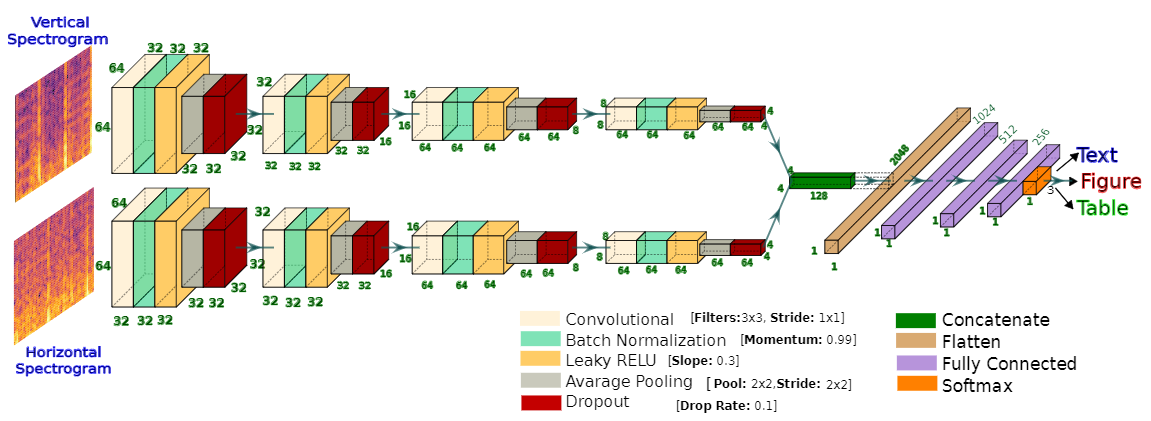




Entradas de la red neuronal convolucional de tamaño 64x64x3

In [ ]:
inputs1 = Input(shape=(64, 64, 3))
inputs2 = Input(shape=(64, 64, 3))

Apilación de bloques y capas para el primer ramal de la red neuronal convolucional

In [ ]:
# 1° Bloque Convolucional
x = Conv2D(32,(3,3),strides=(1,1), padding = 'same')(inputs1)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
x = AveragePooling2D(pool_size=(2,2))(x)
x = Dropout(0.1)(x) 

# 2° Bloque Convolucional
x = Conv2D(32,(3,3),strides=(1,1), padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
x = AveragePooling2D(pool_size=(2,2))(x)
x = Dropout(0.1)(x)

# 3° Bloque Convolucional
x = Conv2D(64,(3,3),strides=(1,1), padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
x = AveragePooling2D(pool_size=(2,2))(x)
x = Dropout(0.1)(x)

# 4° Bloque Convolucional
x = Conv2D(64,(3,3),strides=(1,1), padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.3)(x)
x = AveragePooling2D(pool_size=(2,2))(x)
x = Dropout(0.1)(x)

x = Model(inputs=inputs1, outputs=x)

Apilación de bloques y capas para el segundo ramal de la red neuronal convolucional

In [ ]:
# 1° Bloque Convolucional
y = Conv2D(32,(3,3),strides=(1,1), padding = 'same')(inputs2)
y = BatchNormalization()(y)
y = LeakyReLU(alpha=0.3)(y)
y = AveragePooling2D(pool_size=(2,2))(y)
y = Dropout(0.1)(y) 

# 2° Bloque Convolucional
y = Conv2D(32,(3,3),strides=(1,1), padding = 'same')(y)
y = BatchNormalization()(y)
y = LeakyReLU(alpha=0.3)(y)
y = AveragePooling2D(pool_size=(2,2))(y)
y = Dropout(0.1)(y) 

# 3° Bloque Convolucional
y = Conv2D(64,(3,3),strides=(1,1), padding = 'same')(y)
y = BatchNormalization()(y)
y = LeakyReLU(alpha=0.3)(y)
y = AveragePooling2D(pool_size=(2,2))(y)
y = Dropout(0.1)(y) 

# 4° Bloque Convolucional
y = Conv2D(64,(3,3),strides=(1,1), padding = 'same')(y)
y = BatchNormalization()(y)
y = LeakyReLU(alpha=0.3)(y)
y = AveragePooling2D(pool_size=(2,2))(y)
y = Dropout(0.1)(y) 

y = Model(inputs=inputs2, outputs=y)

Se concatena los dos ramales:

In [ ]:
combined = Concatenate()([x.output, y.output])
combined = Flatten()(combined)

Se añade capas densamente conectadas:

In [ ]:
denseInput= Dense(1024, activation='relu')(combined)
dense1 = Dense(512,activation='relu')(denseInput)
dense2 = Dense(256,activation='relu')(dense1)
predictions = Dense(3, activation='softmax')(dense2)

Se creala el nuevo modelo con las capas anteriormete apiladas:

In [ ]:
model_original = Model(inputs=[x.input, y.input], outputs=predictions)
# Se resume las capas utilizadas en el modelo
model_original.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 64, 64, 32)   896         input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
# Guadar la arquitectura del modelo sin inicialización de pesos
path_save_model = 'CNNTraining/Modelos'
model_original.save(os.path.join(path_save_model, 'Model_without_weights.h5'))

## **5. Entrenamiento de la Red Neuronal Convolucional con Validación Cruzada de K=5 iteraciones**

La validación cruzada de K iteraciones es un método estadístico que permite estimar elperformance de un modelo de Aprendizaje Automático. Para lo cual se divide el conjuntode datos en K subconjuntos del mismo tamaño de forma aleatoria denominados ”Fold”. De esta manera, de los K subconjuntos se toman  K−1 subconjuntos tanto para la fase de entrenamiento como la de validación y el subconjunto sobrante se lo utiliza para la fase de evaluación. El proceso descrito anteriormente se repite K veces considerando en cada iteración un subconjunto distinto para la fase de evaluación. Al efectuar esta técnica se genera K estimaciones en las métricas de evaluación cuyo promedio se emplea como estimación final del performance del modelo.

In [ ]:
## Configuración de la validación cruzada con K=5 iteraciones
path_save_Kfold = 'CNNTraining/KFoldCVInfo'
number_folder = 5
cross_fold_validation = StratifiedKFold(n_splits=number_folder,random_state=125, shuffle=True)

In [ ]:
fold_num = 1
for train_index, test_index in cross_fold_validation.split(df['Identifier'],df['Class']):
  if fold_num >= 1:
    # 1.- División del conjunto de datos en entrenamiento, validación y evaluación 
    df_train_aux = df.iloc[train_index]
    df_train_test = df.iloc[test_index]
    df_train_train, df_train_val = train_test_split(df_train_aux, 
                                                  test_size=0.2, 
                                                  random_state=125, 
                                                  stratify=df_train_aux['Class'])
  
    #2.- Imprime la información de la cantidad de datos contenido en los 
    # conjunto de entrenamiento, validación y prueba
    print('\n\n###########TRAINING FOLD',str(fold_num),'########################')
    print('#####################################################################')   
    print('\n\n############ K-FOLD DATASET DISTRIBUTION #########')
    print('1. TRAINING K=',str(fold_num),' DATASET:',len(df_train_train),'images')
    print(df_train_train['Class'].value_counts())

    print('\n2. VALIDATION K=',str(fold_num),' DATASET:',len(df_train_val),'images')
    print(df_train_val['Class'].value_counts())

    print('\n3. TEST K=',str(fold_num),' DATASET:',len(df_train_test),'images')
    print(df_train_test['Class'].value_counts())
    print(df_train_test.head(5))
  

    # 3.- Tamaño de lotes a usar en la fase de entrenamiento, validación y prueba
    print('\n #################### DECLARE BATCH SIZE #########################')
    num_train_samples = len(df_train_train)
    print('num_train_samples:',num_train_samples)
    num_val_samples = len(df_train_val)
    print('num_val_samples:',num_val_samples)
    num_test_samples = len(df_train_test)
    print('num_test_samples:',num_test_samples)
    train_batch_size = int(len(df_train_train)/20)
    print('train_batch_size:',train_batch_size) 
    val_batch_size =  int(len(df_train_val)/20)
    print('val_batch_size:',val_batch_size) 
    test_batch_size = 1 # 
    print('test_batch_size:',test_batch_size) 

    # 4.- Número de pasos a considerar en cada época del entrenamiento
    print('\n ########### DECLARE HOW MANY STEPS  IN EACH EPOCH  ###################')
    train_steps = np.ceil(num_train_samples / train_batch_size)
    print('train_steps:',train_steps)
    val_steps = np.ceil(num_val_samples / val_batch_size)
    print('val_steps:',val_steps)
    test_steps = np.ceil(num_test_samples / test_batch_size)
    print('test_steps:',test_steps)

    # 5 Iteración de imágenes por lotes
    # 5.1- Iterador de imágenes de entrenamiento
    print('\n ############### TRAINING IMAGES ##############################')
    train_batches = MultipleGenerator(
        dataframe = df_train_train,
        directory = temp_dir,
        x_col1 = 'dir_SpectreV',
        x_col2 = 'dir_SpectreH',
        y_col = 'Class',
        target_size = (64, 64),
        class_mode = 'categorical',
        batch_size = train_batch_size    
        )
    
    # 5.2- Iterador de imágenes de validación
    print('\n #################################### VALIDATION IMAGES ######3##################################')
    val_batches = MultipleGenerator(
        dataframe = df_train_val,
        directory = temp_dir,
        x_col1 = 'dir_SpectreV',
        x_col2 = 'dir_SpectreH',
        y_col = 'Class',
        target_size = (64, 64),
        class_mode = 'categorical',
        batch_size = val_batch_size    
        )
    
    # 5.3- Iterador de imágenes de prueba
    print('\n ################################## TEST IMAGES ###############################################')
    test_batches = MultipleGenerator(
        dataframe = df_train_test,
        directory = temp_dir,
        x_col1 = 'dir_SpectreV',
        x_col2 = 'dir_SpectreH',
        y_col = 'Class',
        target_size = (64, 64),
        class_mode = 'categorical',
        batch_size = test_batch_size    
        )
    
    # 6.- Declaración de técnicas y parámetros para el entrenamiento 
    # 6.1.- Ruta para guardar los modelos en cada iteración
    filepath =  os.path.join(path_save_model,'Fold_' + str(fold_num) + ".h5")

    # 6.2.- Carga del modelo sin los pesos
    model = load_model(os.path.join(path_save_model,'Model_without_weights.h5'))

    # 6.3.- Número de épocas 
    Num_epochs = 1

    # 6.4.- Compilar el modelo para entrenarlo con el algoritmo de optimización
    # Adam. 
    model.compile(Adam(lr=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=[categorical_accuracy])


    # 6.5- Declaración de un punto de control manejado en Python para 
    # guardar la mejor versión del modelo
    checkpoint = ModelCheckpoint(filepath, 
                                 monitor='val_categorical_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')

    # 6.6.- Define el Learning Rate Scheduler
    schedule = CyclicalSchedule(CosineAnnealingSchedule,min_lr=0.0001, 
                                          max_lr=0.001, cycle_length=30)
    ciclo = LearningRateScheduler(schedule,verbose=1)


    # 6.7.- Se define parámetros para la técnica de EarlyStopping
    stop_training = EarlyStopping(monitor='val_categorical_accuracy',
                                  min_delta=0.0002, patience=25, verbose=1)

    # 6.8.- Se define Callback_list para almacenar resultados del entrenamiento 
    callbacks_list = [checkpoint,ciclo,stop_training] 

    # 7. Entrenamiento de la red neuronal convolucional con "fit_generator" de Keras
    print('\n########################TRAINING MODEL ###############################################')
    history = model.fit_generator(generator = train_batches.two_inputs(),
                              steps_per_epoch = train_steps,
                              epochs = Num_epochs,
                              verbose = 1,
                              callbacks=callbacks_list,
                              validation_data = val_batches.two_inputs(),
                              validation_steps = val_steps,
                              validation_freq=1,
                              max_queue_size=10,
                              workers=1,
                              use_multiprocessing=False,
                              shuffle=False,
                              initial_epoch=0)
    # 8.- Evaluación del  modelo entrenado
    # 8.1.- Evaluación del modelo en la última época
    test_loss, test_cat_acc  =  model.evaluate(test_batches.two_inputs(), steps=test_steps)

    print("\n\n####################EVALUATE THE MODEL######################\n\n")
    print("###EVALUATION OF THE LAST EPOCH###")
    print('test_loss:', test_loss)
    print('test_cat_acc:', test_cat_acc)


    # 8.2.-  Evaluación del modelo en la mejor época
    model.load_weights(filepath)
    test_loss, test_cat_acc = model.evaluate(test_batches.two_inputs(), steps=test_steps)
  
    print("\n###EVALUATION OF THE BEST EPOCH###")
    print('test_loss:', test_loss)
    print('test_cat_acc:', test_cat_acc)

    # 9.- Predicción sobre los datos de prueba
    test_batches.genreset()
    y_label = test_batches.labels_classes()
    predictions = model.predict(test_batches.two_inputs(), steps=test_steps, verbose=1)

  
    # 10.- Graficar Resultados
    # 10.1.- Gráfico de matriz de confusión
    print('\n\n###################### PLOTTING CONFUSION MATRIZ #############')
    cm = confusion_matrix(y_label, predictions.argmax(axis=1))
    cm_plot_labels = ['block_text',
                      'figure',
                      'table']
    plt.figure()
    plot_confusion_matrix(cm, cm_plot_labels)
    plt.figure()
    plot_confusion_matrix(cm, cm_plot_labels, normalize=True)
    plt.show()



    # 10.2.- Grafico del accuracy y función de pérdida
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    print('\n\n ############ PLOTTING ACCURANCY AND LOSS #####################33')
    epochs = range(1, len(acc) + 1)
    plt.figure()
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    # 10.3.- Gráfico de la tasa de aprendizaje
    print('\n\n ############ Learning Rate Scheduler #####################33')
    lrs = [schedule(i) for i in epochs]
    plt.plot(epochs, lrs)
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.show()
  
    # 11.- Guardar los resultados obtenidos en la validación cruzada de K iteraciones
    h5path = os.path.join(path_save_Kfold,'InfoDataTraining' + str(fold_num) + '.h5')
    hf = h5py.File(h5path)
    fold_group = hf.create_group('Fold_' + str(fold_num)) 
  
    tr_acc = fold_group.create_dataset("train_acc", data = acc, dtype='f')
    val_acc = fold_group.create_dataset("val_acc", data = val_acc, dtype='f')
    tr_loss = fold_group.create_dataset("train_loss", data = loss, dtype='f')
    val_loss = fold_group.create_dataset("val_loss", data = val_loss, dtype='f')
    y_predictions = fold_group.create_dataset("y_predictions", data = predictions, dtype='f')
    label_test = fold_group.create_dataset("y_label", data = y_label, dtype='f')
    index_train = fold_group.create_dataset("index_train", data = df_train_train.index, dtype='f')
    index_val = fold_group.create_dataset("index_val", data = df_train_val.index, dtype='f')
    index_test = fold_group.create_dataset("index_test", data = df_train_test.index, dtype='f')
    learningRate = fold_group.create_dataset("LearningRate", data = lrs, dtype='f')

    hf.close()


  
  fold_num += 1
